In [ ]:
# INSTALL DEPENDENCIES
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from mne_icalabel import label_components
from mne.time_frequency import tfr_morlet
from collections import defaultdict
from scipy.integrate import simpson
from scipy.signal import welch
from scipy.stats import kurtosis, zscore
import pywt
import plotly.express as px
import dash
from dash import html
import os
from contextlib import contextmanager
from pathlib import Path

In [97]:
# DEFINE PARAMETERS

duration = 2.0
montage = mne.channels.make_standard_montage("standard_1020")
bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 40)
}

# Signal and noise bands
signal_bands = {
    "signal": (1, 40),
    "noise_low": (0.0, 1.0),
    "noise_high": (40.0, 70.0)
}

all_patients_power = defaultdict(list)

channel_mapping = {
    'Ch1': 'Fp1',
    'Ch2': 'AF3',
    'Ch3': 'F7',
    'Ch4': 'F3',
    'Ch5': 'FC1',
    'Ch6': 'FC5',
    'Ch7': 'T7',
    'Ch8': 'C3',
    'Ch9': 'CP1',
    'Ch10': 'CP5',
    'Ch11': 'P7',
    'Ch12': 'P3',
    'Ch13': 'Pz',
    'Ch14': 'PO3',
    'Ch15': 'O1',
    'Ch16': 'Oz',
    'Ch17': 'O2',
    'Ch18': 'PO4',
    'Ch19': 'P4',
    'Ch20': 'P8',
    'Ch21': 'CP6',
    'Ch22': 'CP2',
    'Ch23': 'C4',
    'Ch24': 'T8',
    'Ch25': 'FC6',
    'Ch26': 'FC2',
    'Ch27': 'F4',
    'Ch28': 'F8',
    'Ch29': 'AF4',
    'Ch30': 'Fp2',
    'Ch31': 'Fz',
    'Ch32': 'Cz',
}

montage = mne.channels.make_standard_montage("biosemi32")

In [98]:
# DEFINE & LOAD PRE-ROOM DATA

pre_data_file = "/Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/Follow up/20240513100121_188_Pre Room.edf"
pre_raw = mne.io.read_raw_edf(pre_data_file, preload=True)

# ----- Drop unnecessary or bad channels -----
drop_candidates = ['X', 'Y', 'Z', 'PO3', 'OZ', 'T7', 'F7']
to_drop = [ch for ch in pre_raw.ch_names if ch.strip() in drop_candidates]
if to_drop:
    print(f"Dropping channels: {to_drop}")
    pre_raw.drop_channels(to_drop)

# ----- Rename channels -----
if any(ch in pre_raw.ch_names for ch in channel_mapping.keys()):
    pre_raw.rename_channels(channel_mapping)

Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/Follow up/20240513100121_188_Pre Room.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['T7', 'F7', 'PO3', 'X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/3916027333.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  pre_raw = mne.io.read_raw_edf(pre_data_file, preload=True)


In [99]:
# DEFINE & LOAD POST-ROOM DATA
post_data_file = "/Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/Follow up/20240513102539_188_Post Room.edf"

post_raw = mne.io.read_raw_edf(post_data_file, preload=True)

# ----- Drop unnecessary or bad channels -----
drop_candidates = ['X', 'Y', 'Z', 'PO3', 'OZ', 'T7', 'F7']
to_drop = [ch for ch in post_raw.ch_names if ch.strip() in drop_candidates]
if to_drop:
    print(f"Dropping channels: {to_drop}")
    post_raw.drop_channels(to_drop)

# ----- Rename channels -----
if any(ch in post_raw.ch_names for ch in channel_mapping.keys()):
    post_raw.rename_channels(channel_mapping)

Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/Follow up/20240513102539_188_Post Room.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['T7', 'F7', 'PO3', 'X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/4277606797.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  post_raw = mne.io.read_raw_edf(post_data_file, preload=True)


In [ ]:
def load_edf(data_file):
    """
    load_edf loads in a raw edf file, drops & renames channels, and outputs the raw data
    input: file path to edf file
    output: raw edf file
    """
    raw = mne.io.read_raw_edf(data_file, preload=True)

    # ----- Drop unnecessary or bad channels -----
    drop_candidates = ['X', 'Y', 'Z', 'PO3', 'OZ', 'T7', 'F7']
    to_drop = [ch for ch in raw.ch_names if ch.strip() in drop_candidates]
    if to_drop:
        print(f"Dropping channels: {to_drop}")
        raw.drop_channels(to_drop)

    # ----- Rename channels -----
    if any(ch in raw.ch_names for ch in channel_mapping.keys()):
        raw.rename_channels(channel_mapping)

    return raw
    

def epoch_data(raw):
    """
    epoch_data generates epochs in provided EEG data during every 15 second duration with event code (1 = rest)
    Input: raw edf file
    Output: epochs object with segmented data
    """

    duration = 30.0 # establishes 30 second time window (as long as 60s)
    sfreq = raw.info['sfreq'] # sampling frequency
    n_samples = raw.n_times # number of samples taken

    onset_sample = np.arange(0, n_samples, int(duration * sfreq))
    events = np.column_stack((onset_sample, np.zeros_like(onset_sample, int), np.ones_like(onset_sample, int)))

    epochs = mne.Epochs(
        raw, events,
        event_id={'Rest': 1},
        tmin=0, tmax=duration,
        baseline=None,
        preload=True,
        verbose="ERROR"
    )
    return epochs

def compute_multitaper(data_file):
    """
    compute_multitaper loads & epochs data in edf file and applies a multitaper transform
    input: raw edf file with EEG data
    output: power data (array with shape (epochs, channels, frequencies, times))
    """
    raw = load_edf(data_file)
    epochs = epoch_data(raw)

    # Frequencies of interest
    freqs = np.arange(1, 100, 3)  # 1 to 100 Hz - center frequencies for which transform will be computed
    # Number of cycles per frequency (scales window length with freq)
    n_cycles = freqs * 0.5   # ~0.5 s worth of cycles

    # Frequencies of interest
    freqs = np.arange(1, 100, 3)  # 1 to 100 Hz - center frequencies for which transform will be computed
    # Number of cycles per frequency (scales window length with freq)
    n_cycles = freqs * 0.5   # ~0.5 s worth of cycles

    power = mne.time_frequency.tfr_multitaper(
        epochs,
        # Temporal Window Length = n_cycles/freqs
        freqs=freqs,            # frequencies of interest
        n_cycles=n_cycles,      # number of cycles in wavelet
        time_bandwidth=2.0,   # temporal window length * frequency bandwidth [larger --> lower frequency resolution]
        use_fft=True,         # Use the fft convolution
        return_itc=False,     # return inter-trial coherence & averaged power
        average=False,        # keep one TFR per epoch -> EpochsTFR
        picks="eeg",        # Channels t include
        decim=1,              # keep every nth sample along time
        verbose="ERROR"
    )

    # --- Baseline *on the TFR* (NOT on epochs) ---
    power.apply_baseline(baseline=(0.0, 1.0), mode="ratio")

    return power


def plot_multitaper(epochs):
    """
    plot_multitaper applies a multitaper transform to provided epochs object and outputs the power data
    uses z-score to normalize the power and plots the normalized multitaper time-frequency-representation to store in fig
    input: epochs object with segmented data
    output: figure of TFR, power (power.data = array with shape (epochs, channels, frequencies, times))
    """

    # Frequencies of interest
    freqs = np.arange(1, 100, 3)  # 1 to 100 Hz - center frequencies for which transform will be computed
    # Number of cycles per frequency (scales window length with freq)
    n_cycles = freqs * 0.5   # ~0.5 s worth of cycles

    power = mne.time_frequency.tfr_multitaper(
        epochs,
        # Temporal Window Length = n_cycles/freqs
        freqs=freqs,            # frequencies of interest
        n_cycles=n_cycles,      # number of cycles in wavelet
        time_bandwidth=2.0,   # temporal window length * frequency bandwidth [larger --> lower frequency resolution]
        use_fft=True,         # Use the fft convolution
        return_itc=False,     # return inter-trial coherence & averaged power
        average=False,        # keep one TFR per epoch -> EpochsTFR
        picks="eeg",        # Channels t include
        decim=1,              # keep every nth sample along time
        verbose="ERROR"
    )

    # --- Baseline *on the TFR* (NOT on epochs) ---
    power.apply_baseline(baseline=(0.0, 1.0), mode="ratio")

    # --- Select a single epoch to keep variance high ---
    epoch_idx = 0  # change if you want a different trial
    single = power[epoch_idx].average()   # -> AverageTFR with shape (n_channels, n_freqs, n_times)

    # --- Z-score across time (per freq & channel) ---
    data = single.data                    # (n_channels, n_freqs, n_times)
    mean = data.mean(axis=2, keepdims=True)
    std = data.std(axis=2, keepdims=True)
    std[std == 0] = 1e-10
    z = (data - mean) / std

    # --- Average across channels for display (optional) ---
    avg_z = z.mean(axis=0)                # (n_freqs, n_times)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)
    t = single.times
    f = single.freqs
    im = ax.pcolormesh(t, f, avg_z, shading="auto", cmap="RdBu_r")

    # Robust symmetric color scaling
    vlim = np.nanpercentile(np.abs(avg_z), 98)
    im.set_clim(-vlim, vlim)

    # Annotate baseline window
    ax.axvspan(0.0, 1.0, alpha=0.08, linewidth=0, color="k")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title("Z-scored TFR (TW=2.0, n_cycles = freqs/2)")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Z-score Power")

    plt.show()
    return fig, power

In [111]:
pre_file = "/Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221108153211_RID16Followup_EEG_Pre.easy_converted_.edf"
compute_multitaper(pre_file)

Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221108153211_RID16Followup_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Applying baseline correction (mode: ratio)


Data type,Power Estimates
Data source,Epochs
Number of epochs,19
Dims,"epoch, channel, freq, time"
Estimation method,multitaper
Number of channels,32
Number of timepoints,7501
Number of frequency bins,33
Frequency range,1.00 – 97.00 Hz


In [101]:
# ORIGINAL FILTERING

def filter_raw(raw):
    raw_filtered = raw.copy()

    # ----- Downsample -----
    current_sfreq = raw.info["sfreq"]       # original sampling rate (e.g., 500 Hz)
    desired_sfreq = 250.0                   # what you'd like to work with
    decim = int(np.round(current_sfreq / desired_sfreq))
    obtained_sfreq = current_sfreq / decim  # actual achieved rate
    # lowpass_freq = obtained_sfreq / 3.0     # safe Nyquist cutoff (anti-aliasing buffer)
    lowpass_freq = 70

    # ----- Filtering -----
    raw_filtered.filter(l_freq=1.0, h_freq=None, verbose="ERROR")              # High-pass to remove drift
    raw_filtered.filter(l_freq=None, h_freq=lowpass_freq, verbose="ERROR")    # Low-pass to suppress high-freq noise
    raw_filtered.notch_filter(freqs=[60, 120], verbose="ERROR")               # Remove powerline and harmonics

    # --- Re-reference EEG to common average ---
    raw_filtered.set_eeg_reference('average', projection=True, verbose="ERROR")
    return raw_filtered

In [ ]:
# ICA
def ica_raw(raw):
    raw_ica = raw.copy()

    # ----- Apply montage -----
    try:
        raw_ica.set_montage(montage)
    except ValueError as e:
        print("⚠️ Montage error:", e)
        missing_pos = [ch for ch in raw_ica.ch_names if ch not in montage.ch_names]
        print(f"Missing from montage: {missing_pos}")

    # ----- ICA for artifact removal -----
    ica = mne.preprocessing.ICA(method="infomax", fit_params=dict(extended=True), verbose="ERROR")
    ica.fit(raw_ica)
    ic_labels = label_components(raw_ica, ica, method="iclabel")
    print("IC labels:", ic_labels["labels"])

    labels = ic_labels["labels"]
    exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]
    print(f"Excluding ICA components: {exclude_idx}")
    ica.apply(raw_ica, exclude=exclude_idx)
    return raw_ica

In [103]:
# 3x1 FIGURE OF MULTITAPERS FOR ONE FILE

# --- silence plot_multitaper's plt.show() ---
@contextmanager
def suppress_show():
    orig_show = plt.show
    try:
        plt.show = lambda *a, **k: None
        yield
    finally:
        plt.show = orig_show

# --- rebuild the matrix the same way your plot_multitaper does ---
def _tfr_mat_from_power(power, epoch_idx=0, reduce="mean"):
    """Return (mat, times, freqs) where mat is (n_freqs, n_times) z-scored across time."""
    single = power[epoch_idx].average()        # (C, F, T)
    data = single.data
    mean = data.mean(axis=2, keepdims=True)
    std  = data.std(axis=2, keepdims=True)
    std[std == 0] = 1e-10
    z = (data - mean) / std                    # (C, F, T)
    mat = np.median(z, axis=0) if reduce == "median" else z.mean(axis=0)
    return mat, single.times, single.freqs

def multitaper_steps_figure(raw):
    # Prep three datasets with your existing helpers
    raw_epochs = epoch_data(raw)

    raw_filtered = filter_raw(raw)
    raw_filtered_epochs = epoch_data(raw_filtered)

    raw_ica = ica_raw(raw_filtered)
    raw_ica_epochs = epoch_data(raw_ica)

    # Call your existing plotter, but suppress the individual shows and close their figs
    with suppress_show():
        fig1, pow1 = plot_multitaper(raw_epochs)
        fig2, pow2 = plot_multitaper(raw_filtered_epochs)
        fig3, pow3 = plot_multitaper(raw_ica_epochs)
    plt.close(fig1); plt.close(fig2); plt.close(fig3)

    # Rebuild the matrices for consistent scaling and a shared colorbar
    mats, grids = [], []
    for p in (pow1, pow2, pow3):
        mat, t, f = _tfr_mat_from_power(p, epoch_idx=0, reduce="mean")
        mats.append(mat); grids.append((t, f))

    # Global symmetric color scale
    v = np.nanpercentile(np.abs(np.concatenate([m.ravel() for m in mats])), 98)

    # Plot all three into one figure
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, constrained_layout=True)
    labels = ["Original", "Filtered", "Filtered + ICA"]
    ims = []
    for ax, mat, (t, f), lbl in zip(axs, mats, grids, labels):
        im = ax.pcolormesh(t, f, mat, shading="auto", cmap="RdBu_r", vmin=-v, vmax=v)
        ax.axvspan(0.0, 1.0, alpha=0.08, linewidth=0, color="k")
        ax.set_xlabel("Time (s)"); ax.set_ylabel("Frequency (Hz)")
        ax.set_title(lbl)
        ims.append(im)

    cbar = fig.colorbar(ims[-1], ax=axs, fraction=0.028, pad=0.02)
    cbar.set_label("Z-score Power")
    fig.suptitle("Multitaper TFR", fontsize=12)
    plt.show()
    return fig

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 235.0s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components
    Projecting back using 29 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 103.9s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 6 ICA components
    Projecting back using 29 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)


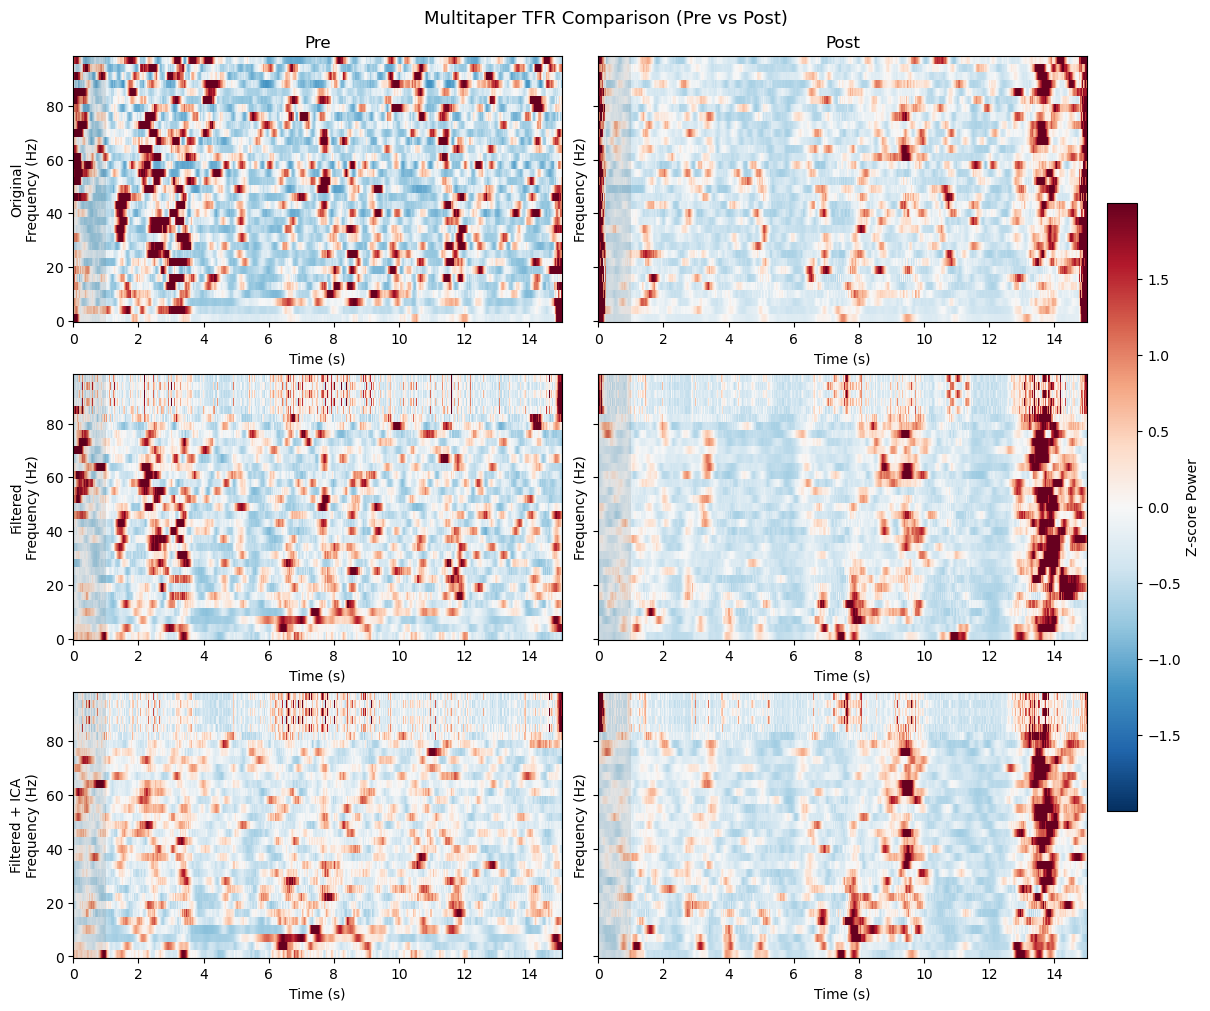

In [104]:
# 3x2 FIGURE COMPARING MULTITAPERS PRE AND POST
# --- silence plt.show() in plot_multitaper ---
@contextmanager
def _suppress_show():
    _orig = plt.show
    try:
        plt.show = lambda *a, **k: None
        yield
    finally:
        plt.show = _orig

# --- unpack result from plot_multitaper (supports 2-tuple or 4-tuple) ---
def _call_plot_get_power(epochs):
    with _suppress_show():
        res = plot_multitaper(epochs)
    fig_tmp = None
    power = None
    if isinstance(res, tuple):
        power = res[-1]               # last item should be the EpochsTFR
        # if the first item looks like a Matplotlib Figure, close it
        try:
            import matplotlib.figure as _mf
            if isinstance(res[0], _mf.Figure):
                fig_tmp = res[0]
        except Exception:
            pass
    else:
        power = res
    if fig_tmp is not None:
        plt.close(fig_tmp)
    return power

# --- Use z-score + channel-average to get a 2D (F,T) matrix ---
def _tfr_mat_from_power(power, epoch_idx=0, reduce="mean"):
    """Return (mat, times, freqs) with z-scoring across time per channel/freq."""
    single = power[epoch_idx].average()  # (C, F, T)
    data = single.data
    mean = data.mean(axis=2, keepdims=True)
    std  = data.std(axis=2, keepdims=True)
    std[std == 0] = 1e-10
    z = (data - mean) / std              # (C, F, T)
    mat = np.median(z, axis=0) if reduce == "median" else z.mean(axis=0)  # (F, T)
    return mat, single.times, single.freqs

def multitaper_comparison_figure(pre_raw, post_raw, *, epoch_idx=0, reduce="mean",
                                 clim_percentile=98, baseline=(0.0, 1.0), show=True):
    """
    Build a 3x2 comparison figure:
      rows: Original / Filtered / Filtered+ICA
      cols: Pre | Post
    Uses your existing epoch_data, filter_raw, ica_raw, plot_multitaper.
    """
    # ---------- PRE pipeline ----------
    pre_epochs = epoch_data(pre_raw)
    pre_power_orig = _call_plot_get_power(pre_epochs)

    pre_filt_raw = filter_raw(pre_raw)
    pre_filt_epochs = epoch_data(pre_filt_raw)
    pre_power_filt = _call_plot_get_power(pre_filt_epochs)

    pre_ica_raw = ica_raw(pre_filt_raw)
    pre_ica_epochs = epoch_data(pre_ica_raw)
    pre_power_ica = _call_plot_get_power(pre_ica_epochs)

    # ---------- POST pipeline ----------
    post_epochs = epoch_data(post_raw)
    post_power_orig = _call_plot_get_power(post_epochs)

    post_filt_raw = filter_raw(post_raw)
    post_filt_epochs = epoch_data(post_filt_raw)
    post_power_filt = _call_plot_get_power(post_filt_epochs)

    post_ica_raw = ica_raw(post_filt_raw)
    post_ica_epochs = epoch_data(post_ica_raw)
    post_power_ica = _call_plot_get_power(post_ica_epochs)

    # ---------- Rebuild (F,T) matrices (z-scored across time), and collect for scaling ----------
    panels = []
    for p in [pre_power_orig, pre_power_filt, pre_power_ica,
              post_power_orig, post_power_filt, post_power_ica]:
        mat, t, f = _tfr_mat_from_power(p, epoch_idx=epoch_idx, reduce=reduce)
        panels.append((mat, t, f))

    # Global symmetric color scale across all six panels
    v = np.nanpercentile(
        np.abs(np.concatenate([m.ravel() for (m, _, _) in panels])), clim_percentile
    )

    # ---------- Make figure: 3 rows (proc steps) × 2 cols (pre/post) ----------
    fig, axs = plt.subplots(3, 2, figsize=(12, 10), sharey=True, constrained_layout=True)

    row_labels = ["Original", "Filtered", "Filtered + ICA"]
    col_labels = ["Pre", "Post"]

    # Set column titles
    axs[0, 0].set_title(col_labels[0])
    axs[0, 1].set_title(col_labels[1])

    # Plot order maps to rows/cols:
    # rows:   0: original, 1: filtered, 2: filtered+ica
    # cols:   0: pre, 1: post
    mats_iter = [
        panels[0], panels[3],   # original: pre, post
        panels[1], panels[4],   # filtered: pre, post
        panels[2], panels[5],   # ica:      pre, post
    ]

    ims = []
    for r in range(3):
        for c in range(2):
            ax = axs[r, c]
            mat, t, f = mats_iter[r*2 + c]
            im = ax.pcolormesh(t, f, mat, shading="auto", cmap="RdBu_r",
                               vmin=-v, vmax=v)
            ims.append(im)
            # annotate baseline window (same as your plotter)
            if baseline is not None:
                ax.axvspan(baseline[0], baseline[1], alpha=0.08, linewidth=0, color="k")
            ax.set_xlabel("Time (s)")
            if c == 0:
                # Row labels on the left along with y-axis label
                ax.set_ylabel(f"{row_labels[r]}\nFrequency (Hz)")
            else:
                ax.set_ylabel("Frequency (Hz)")

    # Shared colorbar
    cbar = fig.colorbar(ims[-1], ax=axs, fraction=0.03, pad=0.02)
    cbar.set_label("Z-score Power")

    fig.suptitle("Multitaper TFR Comparison (Pre vs Post)", fontsize=13)

    if show:
        plt.show()
        return None
    return fig

multitaper_comparison_figure(pre_raw, post_raw, epoch_idx=0, reduce="mean", clim_percentile=98, baseline=(0.0, 1.0), show=True)

In [105]:
def multitaper_average(
    folder_path,
    *,
    extensions=(".edf",),          # which files to include
    recursive=True,
    epoch_idx=0,                   # which epoch per file to use; set None to average epochs first
    channel_reduce="mean",         # "mean" or "median" across channels
    clim_percentile=98,            # symmetric scaling for the colormap
    cmap="RdBu_r",
    annotate_baseline=(0.0, 1.0),  # just for drawing the shaded baseline window
    show=True
):
    """
    Walk through a folder of EDFs, compute multitaper TFR per file using compute_multitaper function,
    z-score across time per (channel,freq), reduce channels, then average the 2-D TFR
    across files to get a group summary.

    Returns
    -------
    fig : matplotlib.figure.Figure
    avg_mat : (n_freqs, n_times) float array (group-average z-scored power)
    times : (n_times,) array (seconds)
    freqs : (n_freqs,) array (Hz)
    per_file : list of dicts with {'path','mat','times','freqs'}
    """
    folder = Path(folder_path).expanduser()
    if not folder.exists():
        raise FileNotFoundError(f"Folder not found: {folder}")

    # Gather files
    if recursive:
        files = [p for p in folder.rglob("*") if p.is_file() and p.suffix.lower() in {e.lower() for e in extensions}]
    else:
        files = [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in {e.lower() for e in extensions}]
    files = sorted(files)
    if not files:
        raise ValueError(f"No files with extensions {extensions} found in {folder}")

    mats = []
    per_file = []
    times_ref = None
    freqs_ref = None

    for fpath in files:
        # --- your pipeline: compute multitaper TFR (EpochsTFR) ---
        power = compute_multitaper(str(fpath))    # uses your load_edf + epoch_data internally

        # --- select epoch or average epochs first ---
        single = power.average() if epoch_idx is None else power[epoch_idx].average()   # (C,F,T)

        data = single.data  # (n_channels, n_freqs, n_times)

        # --- z-score across time per (channel,freq) ---
        mean = data.mean(axis=-1, keepdims=True)
        std  = data.std(axis=-1, keepdims=True)
        std[std == 0] = 1e-10
        z = (data - mean) / std                    # (C,F,T)

        # --- reduce channels to get a 2-D (F,T) matrix ---
        if channel_reduce == "median":
            mat = np.nanmedian(z, axis=0)
        else:
            mat = np.nanmean(z, axis=0)

        mats.append(mat)

        # grids (sanity: ensure alignment across files)
        if times_ref is None:
            times_ref = single.times
            freqs_ref = single.freqs
        else:
            if not np.allclose(times_ref, single.times):
                raise ValueError(f"Time axis mismatch in {fpath.name}")
            if not np.allclose(freqs_ref, single.freqs):
                raise ValueError(f"Freq axis mismatch in {fpath.name}")

        per_file.append({"path": str(fpath), "mat": mat, "times": times_ref, "freqs": freqs_ref})

    # --- average across files ---
    stack = np.stack(mats, axis=0)   # (N_files, F, T)
    avg_mat = np.nanmean(stack, axis=0)

    # --- plot group TFR ---
    fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
    v = np.nanpercentile(np.abs(stack), clim_percentile)  # robust, symmetric
    im = ax.pcolormesh(times_ref, freqs_ref, avg_mat, shading="auto", cmap=cmap, vmin=-v, vmax=v)

    if annotate_baseline is not None:
        ax.axvspan(annotate_baseline[0], annotate_baseline[1], alpha=0.08, linewidth=0, color="k")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title(f"Group TFR (z-scored per file)  |  N={len(files)}")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Z-score Power")

    if show:
        plt.show()

    return fig, avg_mat, times_ref, freqs_ref, per_file

Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221108153211_RID16Followup_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221108155948_RID16_Followup_EEG_Post.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221109121641_RID18Followup_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221109124411_RID18_FollowupEEG_Post.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221115131100_RID33_Followup_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221115134027_RID33_Followup_EEG_Post.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221123162912_RID12_11.23.22_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Applying baseline correction (mode: ratio)


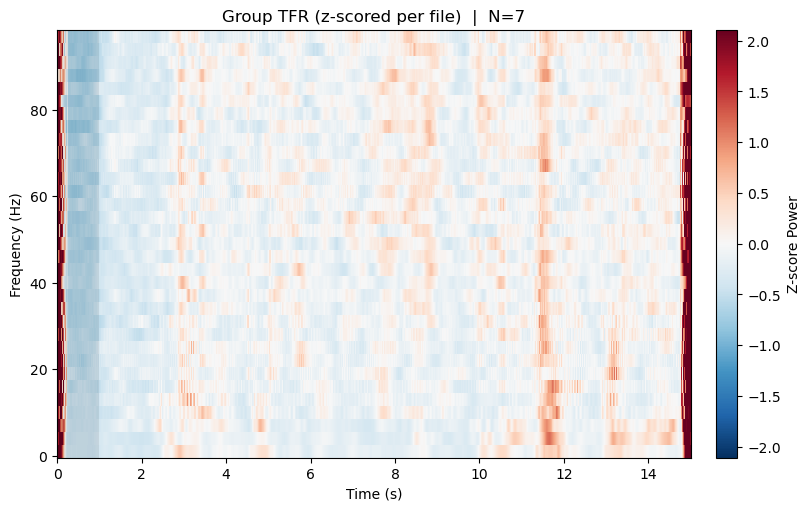

In [107]:
folder = "/Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost"

# Or average epochs within each file first (often more stable):
fig, avg_mat, times, freqs, details = multitaper_average(folder, epoch_idx=None)

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import mne

def multitaper_group_comparison_figure(
    pre_folder, post_folder,
    *,
    extensions=(".edf",),
    recursive=True,
    epoch_idx=0,                 # pick a specific epoch per file; set to None to average epochs first
    reduce="mean",               # how to reduce channels & files: "mean" or "median"
    baseline=(0.0, 1.0),         # baseline used on TFR (must match across files)
    freqs=np.arange(1, 100, 3),
    n_cycles=None,               # None -> freqs*0.5 (~0.5 s windows)
    time_bandwidth=2.0,
    picks="eeg",
    decim=1,
    clim_percentile=98,
    cmap="RdBu_r",
    show=True
):
    """
    Build a 3x2 figure of *averaged* multitaper TFRs across files.
      rows: Original | Filtered | Filtered + ICA
      cols: Pre | Post

    Uses your load_edf, epoch_data, filter_raw, ica_raw. For each file:
      - compute EpochsTFR
      - either take epoch_idx or average epochs
      - z-score across time per (channel, freq)
      - reduce channels (mean/median) -> (F, T)
    Then average (across files) per step and plot.

    Returns
    -------
    fig : matplotlib.figure.Figure (or None if show=True and you’re in a notebook rich-display)
    results : dict with group mats and grids:
        {
          'pre':  {'original': mat, 'filtered': mat, 'ica': mat, 'times': ..., 'freqs': ...},
          'post': {'original': mat, 'filtered': mat, 'ica': mat, 'times': ..., 'freqs': ...}
        }
    """
    # ---- helpers ----
    def _files_in(folder):
        folder = Path(folder).expanduser()
        if not folder.exists():
            raise FileNotFoundError(f"Folder not found: {folder}")
        if recursive:
            files = [p for p in folder.rglob("*") if p.is_file() and p.suffix.lower() in {e.lower() for e in extensions}]
        else:
            files = [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in {e.lower() for e in extensions}]
        return sorted(files)

    def _resolve_n_cycles(freqs, n_cycles):
        if n_cycles is None:
            return freqs * 0.5
        return n_cycles

    def _power_from_raw(raw):
        # epoch then multitaper (mirrors your compute_multitaper, but accepts raw at any processing step)
        epochs = epoch_data(raw)
        ncy = _resolve_n_cycles(freqs, n_cycles)
        power = mne.time_frequency.tfr_multitaper(
            epochs,
            freqs=freqs,
            n_cycles=ncy,
            time_bandwidth=time_bandwidth,
            use_fft=True,
            return_itc=False,
            average=False,
            picks=picks,
            decim=decim,
            verbose="ERROR",
        )
        if baseline is not None:
            power.apply_baseline(baseline=baseline, mode="ratio")
        return power

    def _mat_from_power(power):
        # choose epoch or average epochs, then z-score across time per (ch,freq),
        # then reduce channels -> (F, T)
        single = power.average() if epoch_idx is None else power[epoch_idx].average()  # (C,F,T)
        data = single.data
        mean = data.mean(axis=-1, keepdims=True)
        std  = data.std(axis=-1, keepdims=True)
        std[std == 0] = 1e-10
        z = (data - mean) / std                                        # (C,F,T)
        mat = (np.nanmedian if reduce == "median" else np.nanmean)(z, axis=0)  # (F,T)
        return mat, single.times, single.freqs

    def _process_folder(folder):
        """Return dict: {'original': mats, 'filtered': mats, 'ica': mats, 'times': arr, 'freqs': arr}."""
        files = _files_in(folder)
        if not files:
            raise ValueError(f"No {extensions} files found in {folder}")

        mats_orig, mats_filt, mats_ica = [], [], []
        times_ref = freqs_ref = None

        for fpath in files:
            # Load & stepwise processing using your helpers
            raw0 = load_edf(str(fpath))              # original
            raw1 = filter_raw(raw0.copy())           # filtered
            raw2 = ica_raw(raw1.copy())              # filtered + ICA

            # Compute TFRs at each step
            p0 = _power_from_raw(raw0)
            p1 = _power_from_raw(raw1)
            p2 = _power_from_raw(raw2)

            # Convert to (F,T) matrices
            for pwr, collector in [(p0, mats_orig), (p1, mats_filt), (p2, mats_ica)]:
                mat, t, f = _mat_from_power(pwr)
                collector.append(mat)
                # grid consistency
                if times_ref is None:
                    times_ref, freqs_ref = t, f
                else:
                    if not np.allclose(times_ref, t):
                        raise ValueError(f"Time axis mismatch in {fpath.name}")
                    if not np.allclose(freqs_ref, f):
                        raise ValueError(f"Frequency axis mismatch in {fpath.name}")

        # Average across files for each step
        stack = lambda L: np.stack(L, axis=0)  # (N_files, F, T)
        reduce_files = (np.nanmedian if reduce == "median" else np.nanmean)
        out = {
            "original": reduce_files(stack(mats_orig), axis=0),
            "filtered": reduce_files(stack(mats_filt), axis=0),
            "ica":      reduce_files(stack(mats_ica),  axis=0),
            "times":    times_ref,
            "freqs":    freqs_ref,
        }
        return out

    # ---- compute group mats for pre & post ----
    pre = _process_folder(pre_folder)
    post = _process_folder(post_folder)

    # ---- global symmetric color scale across the six averaged panels ----
    all_panels = [
        pre["original"],  post["original"],
        pre["filtered"],  post["filtered"],
        pre["ica"],       post["ica"],
    ]
    v = np.nanpercentile(np.abs(np.concatenate([m.ravel() for m in all_panels])), clim_percentile)

    # ---- plot 3×2 figure ----
    fig, axs = plt.subplots(3, 2, figsize=(12, 10), sharey=True, constrained_layout=True)

    row_labels = ["Original", "Filtered", "Filtered + ICA"]
    col_labels = ["Pre", "Post"]

    # column titles
    axs[0, 0].set_title(col_labels[0])
    axs[0, 1].set_title(col_labels[1])

    order = [
        (pre["original"],  post["original"]),
        (pre["filtered"],  post["filtered"]),
        (pre["ica"],       post["ica"]),
    ]

    ims = []
    for r, (mat_pre, mat_post) in enumerate(order):
        for c, mat in enumerate((mat_pre, mat_post)):
            ax = axs[r, c]
            im = ax.pcolormesh(pre["times"], pre["freqs"], mat, shading="auto", cmap=cmap,
                               vmin=-v, vmax=v)
            ims.append(im)
            if baseline is not None:
                ax.axvspan(baseline[0], baseline[1], alpha=0.08, linewidth=0, color="k")
            ax.set_xlabel("Time (s)")
            if c == 0:
                ax.set_ylabel(f"{row_labels[r]}\nFrequency (Hz)")
            else:
                ax.set_ylabel("Frequency (Hz)")

    cbar = fig.colorbar(ims[-1], ax=axs, fraction=0.03, pad=0.02)
    cbar.set_label("Z-score Power")

    fig.suptitle("Multitaper Group Comparison (Pre vs Post)", fontsize=13)

    if show:
        plt.show()
        return None, {"pre": pre, "post": post}
    else:
        return fig, {"pre": pre, "post": post}


Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPre/20221005161518_18Baseline_pre_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Fitting ICA took 19.6s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPre/20221005164813_18Baseline_post_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Fitting ICA took 30.8s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPre/20221006161913_16Baseline_pre_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 30 components
Computing Extended Infomax ICA
Fitting ICA took 25.7s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPre/20221006164702_16Baseline_post_EEG_Post.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 30 components
Computing Extended Infomax ICA
Fitting ICA took 19.3s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPre/20221014082145_12_10.14.22_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 29 components
Computing Extended Infomax ICA
Fitting ICA took 50.0s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (29 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPre/20221014090443_12_10.14.22_EEG_Post.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 30 components
Computing Extended Infomax ICA
Fitting ICA took 247.9s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221108153211_RID16Followup_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 16.9s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221108155948_RID16_Followup_EEG_Post.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 22.7s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221109121641_RID18Followup_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 15.8s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:15: RuntimeWarning: Using n_components=None (resulting in n_components_=25) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 24
  ica.fit(raw_ica)
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify feature

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221109124411_RID18_FollowupEEG_Post.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 16.2s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:15: RuntimeWarning: Using n_components=None (resulting in n_components_=26) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 25
  ica.fit(raw_ica)
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify feature

Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221115131100_RID33_Followup_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 37.2s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221115134027_RID33_Followup_EEG_Post.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 54.5s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
Extracting EDF parameters from /Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost/20221123162912_RID12_11.23.22_EEG_Pre.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Dropping channels: ['X', 'Y', 'Z']


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/51067524.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data_file, preload=True)


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 37.3s.


/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
/var/folders/dp/pmyt5sdd6sj7q3msxftb64x80000gn/T/ipykernel_62807/1904262256.py:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: ratio)


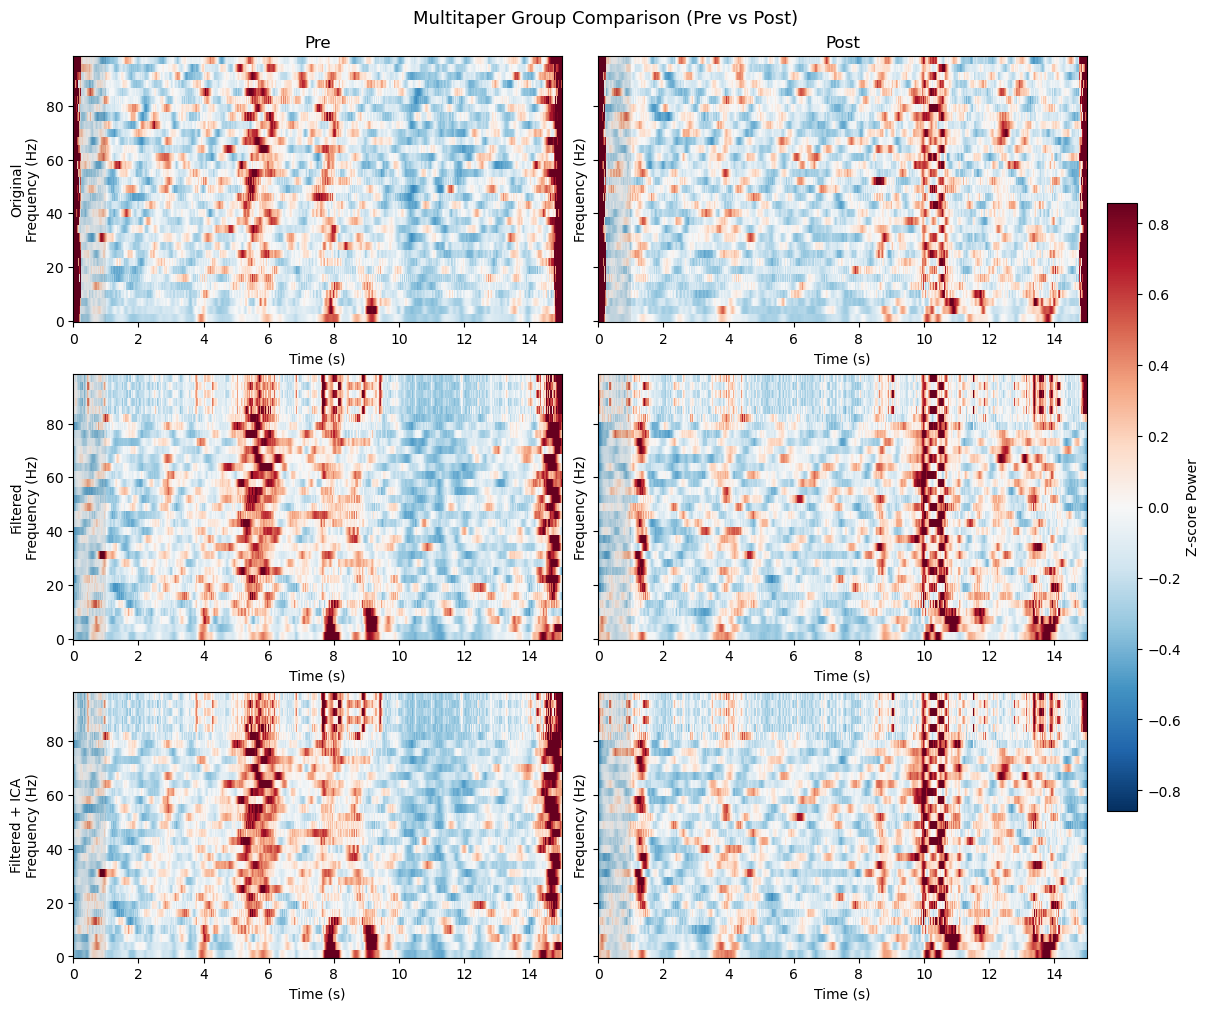

In [110]:
pre_folder  = "/Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPre"
post_folder = ("/Users/cassidyschuman/Downloads/Research/Mount Sinai/Data Analysis/ARC_VS/EEG_RECHARGE_DATA/AverageTestPost")

# Use the first epoch from each file (max variance)
_, results = multitaper_group_comparison_figure(pre_folder, post_folder, epoch_idx=0, reduce="mean")

# Or average epochs within each file for stability:
# _, results = multitaper_group_comparison_figure(pre_folder, post_folder, epoch_idx=None, reduce="mean")